In [1]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


## Load Analytical Base Table

In [2]:
df = pd.read_csv(os.path.join("../Resources", "analytical_base_table.csv"))
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Separate dataframe into separate object

In [3]:
# Object for target variable
y = df.Exited

# object for input features
X = df.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [6]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    dff = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    dff['Count'] = dff['Count'].astype('int64')
    dff['%'] = round(dff['Count'] / a.shape[0] * 100, 2)
    return dff.sort_values('Count',ascending=False)

In [7]:
class_count(y)

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


## Create a Train Test Split

In [8]:
random_state = 10

# Split X and y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                   stratify=df.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


## Pre-processing Pipeline

### Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder

Create lists of indexes from the list of column names

Need to be numeric not string to specify columns name in column transformer

In [10]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 3, 4, 5, 6, 7, 8, 9]


In [11]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)  

[1, 2]


In [12]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2])])

## Build Model Pipeline with SMOTE

* We are going to use the Pipeline from the imblearn package in place of scikit-learn Pipeline.

* It takes care automatically to re-sample when called fit() on the pipeline, and does not re-sample test data (when called transform() or predict()).

In [13]:
# Import XGBoost
import xgboost as xgb

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  xgb.XGBClassifier(use_label_encoder=False, random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                              

In [14]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [15]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {'xgbclassifier__gamma': [0.5, 0.8, 1],
              'xgbclassifier__max_depth': [3, 4, 5, 6],
              'xgbclassifier__n_estimators': [50, 100, 200]
        }
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='f1_macro')


In [16]:
X_train = X_train.values
X_test = X_test.values

In [17]:
# Train the model with GridSearch
grid.fit(X_train, y_train, xgbclassifier__eval_metric='logloss')


Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\ishit\Bank-Churn-Prediction\server\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ishit\Bank-Churn-Prediction\server\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ishit\Bank-Churn-Prediction\server\venv\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\ishit\Bank-Churn-Prediction\server\venv\lib\site-packages\xgboost\core.py",

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'

In [18]:
# Define model with pipeline
model = imbl_pipe(
    preprocess,
    SMOTE(sampling_strategy='auto', random_state=random_state),
    xgb.XGBClassifier(use_label_encoder=False, random_state=random_state, eval_metric='logloss')
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'xgbclassifier__gamma': [0.5, 0.8, 1],
    'xgbclassifier__max_depth': [3, 4, 5, 6],
    'xgbclassifier__n_estimators': [50, 100, 200],
    'xgbclassifier__eval_metric': ['logloss']  # If needed, include this in the grid for exploration
}

# Create the GridSearchCV model
grid = GridSearchCV(model, param_grid, verbose=3, cv=5, n_jobs=4, scoring='f1_macro')

# Fit the model
grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\ishit\Bank-Churn-Prediction\server\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2])

In [19]:
print(grid.best_params_)

{'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.8, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 100}


In [20]:
 # List the best score
print(grid.best_score_)

0.7612982384579798


In [21]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.8106322732916824
Testing Data Score: 0.766781181961393


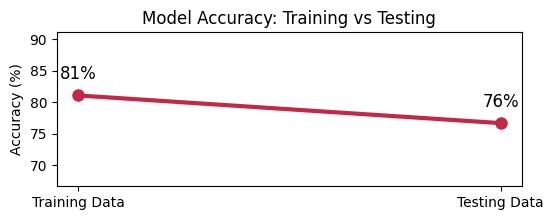

In [36]:
import matplotlib.pyplot as plt

# Data
scores = [grid.score(X_train, y_train) * 100, grid.score(X_test, y_test) * 100]
labels = ['Training Data', 'Testing Data']

# Create a figure with smaller size
plt.figure(figsize=(6, 2))  # Adjust the width and height as needed

# Plot with pastel pink color for the line
plt.plot(labels, scores, marker='o', color='#C42847', linestyle='-', linewidth=3, markersize=8)

# Set the Y-axis limits to center the line
plt.ylim(min(scores) - 10, max(scores) + 10)  # Adjust this to make sure the line is centered within the plot

# Add labels and title
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy: Training vs Testing')

# Adding the text on the plot
for i in range(len(scores)):
    plt.text(labels[i], scores[i] + 2, f'{int(scores[i])}%', ha='center', va='bottom', fontsize=12)

plt.show()


In [25]:
# Make predictions with the hypertuned model
pred = grid.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, pred)
print(cm)

[[2187  202]
 [ 241  370]]


In [27]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.92 0.08]
 [0.39 0.61]]


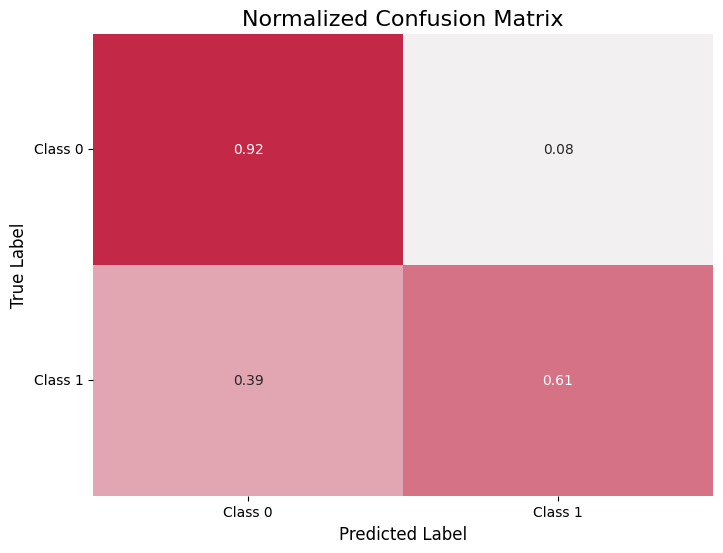

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example normalized confusion matrix
cm = np.array([[0.92, 0.08], 
               [0.39, 0.61]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap=sns.light_palette("#C42847", as_cmap=True), cbar=False)

# Add labels, title, and axes
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=10)
plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], fontsize=10, rotation=0)

plt.show()


In [28]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2389
           1       0.65      0.61      0.63       611

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



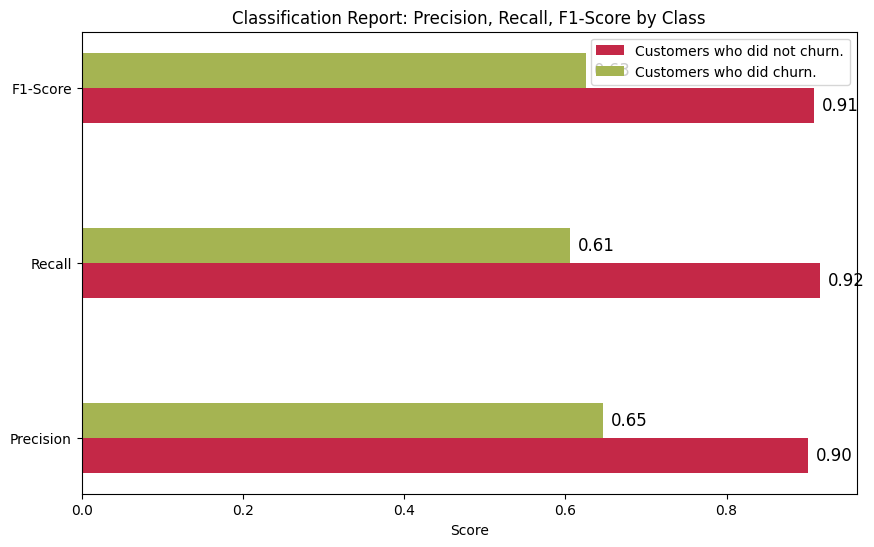

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Sample classification report data
report = classification_report(y_test, pred, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision_class_0 = report['0']['precision']
recall_class_0 = report['0']['recall']
f1_class_0 = report['0']['f1-score']

precision_class_1 = report['1']['precision']
recall_class_1 = report['1']['recall']
f1_class_1 = report['1']['f1-score']

# Set up the positions for each bar
metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [precision_class_0, recall_class_0, f1_class_0]
class_1_values = [precision_class_1, recall_class_1, f1_class_1]

# Bar colors
class_0_color = '#C42847'  # Purple for class 0
class_1_color = '#A5B452'  # Olive for class 1

# Set the figure size
plt.figure(figsize=(10, 6))

# Create horizontal bars
bar_width = 0.2  # Reduced width of bars
index = np.arange(len(metrics))  # Position for each metric

# Plot bars for class 0 and class 1, side by side
bars_class_0 = plt.barh(index - bar_width / 2, class_0_values, bar_width, label='Customers who did not churn.', color=class_0_color)
bars_class_1 = plt.barh(index + bar_width / 2, class_1_values, bar_width, label='Customers who did churn.', color=class_1_color)

# Add labels and title
plt.xlabel('Score')
plt.title('Classification Report: Precision, Recall, F1-Score by Class')
plt.yticks(index, metrics)  # Set y-axis to show metrics
plt.legend()

# Adding text labels for the values on top of the bars
for i, bar in enumerate(bars_class_0):
    # Add value for class 0
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_0_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

for i, bar in enumerate(bars_class_1):
    # Add value for class 1
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_1_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

# Display the plot
plt.show()


In [29]:
print(f"Predicted classes: \t{list(pred[:10])}")
print(f"Actual Labels: \t\t{list(y_test[:10])}")

Predicted classes: 	[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Actual Labels: 		[1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


## Save the Model

In [30]:
import joblib

# We are saving our grid model
filename = '../models/XGBoost_model.sav'
joblib.dump(grid, filename)

['../models/XGBoost_model.sav']

## Loading the Model

In [31]:
# load the model
xgb_model = joblib.load(filename)
print(xgb_model.score(X_test, y_test))

0.766781181961393


### Predict class for new data

In [32]:
# Let's use the first X_test record as new data
X_test[:1]

array([[638, 'France', 'Male', 36, 6, 188455.19, 1, 0, 0, 47031.4]],
      dtype=object)

In [33]:
pred_new = xgb_model.predict(X_test[:1])

In [34]:
print(f"Predicted classes: \t{pred_new}")
print(f"Actual Labels: \t\t{list(y_test[:1])}")

Predicted classes: 	[0]
Actual Labels: 		[1]


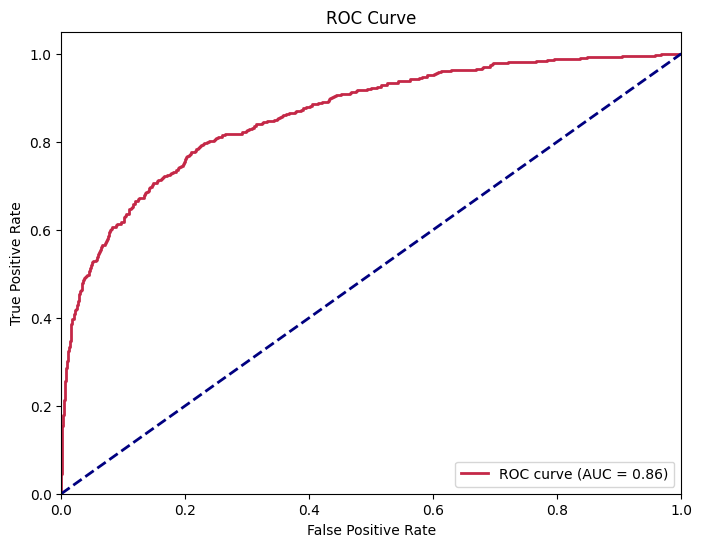

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_prob = grid.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#C42847', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


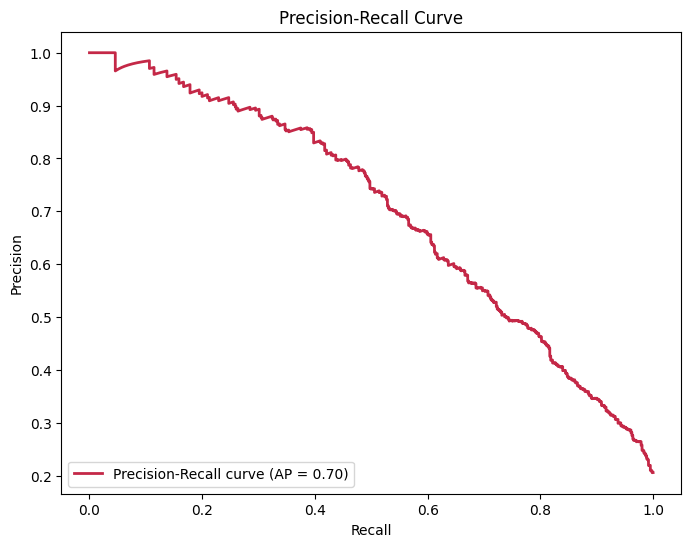

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class (class 1)
y_prob = grid.predict_proba(X_test)[:, 1]

# Compute precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute average precision score
avg_precision = average_precision_score(y_test, y_prob)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#C42847', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


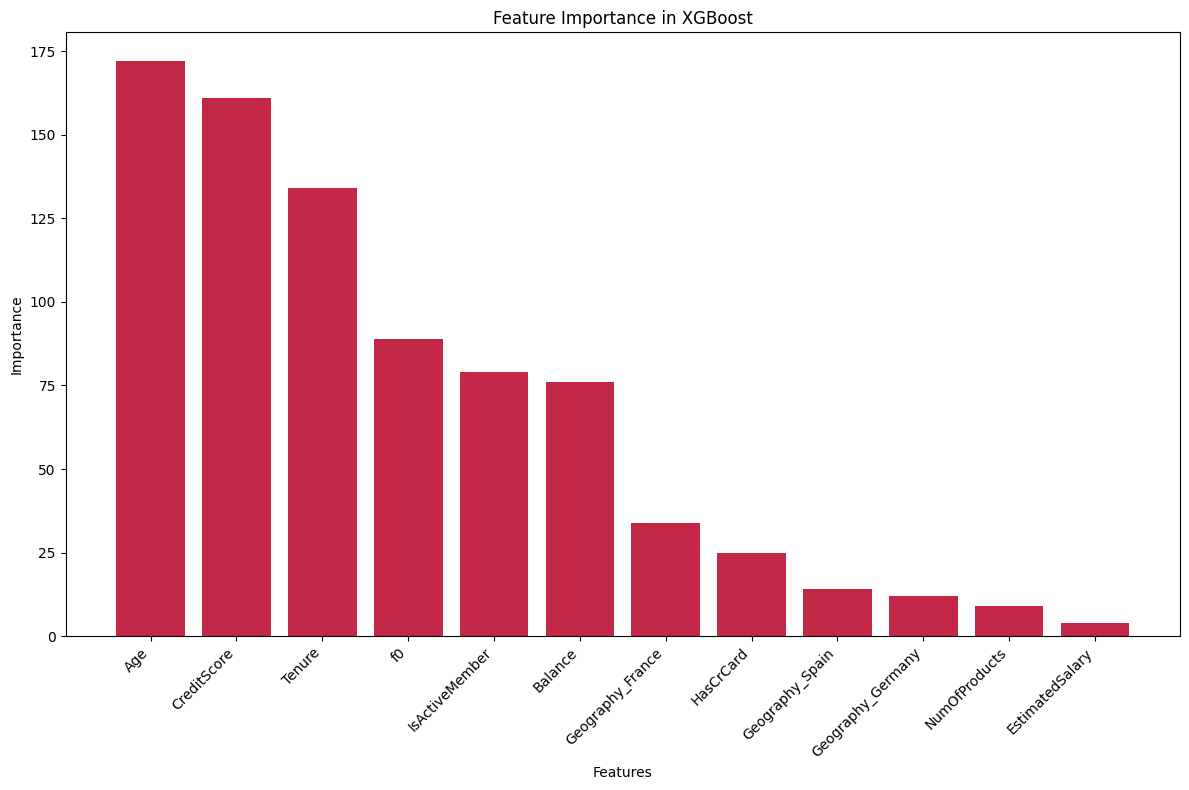

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance_xgboost(model, original_num_features, original_cat_features, X_train):
    """
    Plots a feature importance graph based on the XGBoost model.

    Parameters:
    model : Trained XGBoost model (GridSearchCV object)
    original_num_features : List of original numerical feature names
    original_cat_features : List of original categorical feature names
    X_train : Training data (used to fit the preprocessor)
    """
    # Access the pipeline
    pipeline = model.best_estimator_

    # Extract the preprocessor and XGBoost components
    preprocessor = pipeline.named_steps['columntransformer']
    xgb_model = pipeline.named_steps['xgbclassifier']

    # Get the transformed feature names from the preprocessor
    num_feature_names = original_num_features
    cat_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(original_cat_features)

    # Combine numerical and one-hot encoded categorical feature names
    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Get the feature importance from the XGBoost model
    booster = xgb_model.get_booster()  # Extract the booster object
    importance = booster.get_score(importance_type='weight')  # Using weight as the importance type

    # Sort features by importance
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    sorted_features = np.array(sorted_features)

    # Extract the sorted feature names and importance values
    sorted_feature_names = sorted_features[:, 0]
    sorted_importance = sorted_features[:, 1].astype(float)

    # Map the internal feature names (f1, f2, etc.) to the original feature names
    feature_mapping = {f"f{i+1}": all_feature_names[i] for i in range(len(all_feature_names))}
    mapped_feature_names = [feature_mapping.get(f, f) for f in sorted_feature_names]

    # Plot the feature importance
    plt.figure(figsize=(12, 8))
    plt.bar(mapped_feature_names, sorted_importance, color='#C42847')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance in XGBoost")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function with necessary arguments
plot_feature_importance_xgboost(grid, num_columns, cat_columns, X_train)
